In [1]:
import re
import os
import sys
import logging
import ast

import polars as pl

from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, r2_score, 
								mean_squared_error, mean_absolute_error, accuracy_score, f1_score, median_absolute_error)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import optuna
from optuna.samplers import TPESampler


import os
import re
from pathlib import Path
from typing import Union, Tuple, List, Optional
from collections.abc import Callable


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.modelling.data import *
from utils.modelling.evaluation import *
from utils.modelling.training import *
from utils.modelling.tuning import *

/Users/tung/Repos/cxc2025-federato/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training Regressor Model

## import data


In [3]:
df = pl.read_parquet('/kaggle/input/eda-dataset/preprocessed_data.parquet')
df

session_id,user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,returned_within_28_days_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,session_seconds_mean,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,slug_encoded_mean
i64,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i32,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1738009295198,"""acb60a19-d8c0-4924-88c8-78ccda…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,937.0,20.0,19.851852,20.0,19.851852,19.851852,1076.148148,0.0,3.592593,0.044815
1735916130662,"""6cd4ff43-3226-4bbf-8203-5d0147…",0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0.0,14.0,14.5,14.0,14.5,14.5,1598.75,0.0,1.5,0.045
1714423842058,"""bbf4e34e-e76a-46e3-a5c4-cfa9c5…",0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,16.0,20.0,20.0,20.0,20.0,20.0,2.0,0.0,0.6,0.0
1722269362779,"""94c518d5-37d3-4c2d-8c2b-72e9fb…",0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,16.0,16.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0
1696438324976,"""f8494058-23b9-466c-a10b-f201a1…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,6.0,16.0,17.0,16.0,17.0,17.0,1.4778e7,0.0,10.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1715645444982,"""afe99d2f-4fce-4584-a360-967b87…",1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,2.0,0.0
1711108354862,"""f0457050-c716-4f31-8755-f256a9…",0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,551.0,11.25,1.0,11.25,1.0,1.0,827437.75,0.0,150.75,0.0
1726687903267,"""cd3715bf-0c84-41f2-aa54-345093…",0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,33.0,19.0,18.666667,19.0,18.666667,18.666667,3671.0,0.0,1.0,0.02


In [4]:
df = df.with_columns(
 pl.col('user_id_first').map_elements(lambda x: x[-1], return_dtype=pl.String).alias('train')
) 

In [5]:
df['train'].value_counts().with_columns(
    pl.col('count').map_elements(lambda x: x/df.shape[0])
)

<ipython-input-5-e72ca0130cb4>:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df['train'].value_counts().with_columns(


train,count
str,f64
"""6""",0.05603
"""e""",0.033676
"""1""",0.071528
"""4""",0.083371
"""d""",0.056844
…,…
"""b""",0.073387
"""7""",0.076682
"""8""",0.031936


In [6]:
df = df.drop(["session_id", "user_id_first"])

In [7]:
df_test = df.filter((pl.col('train') == '5') | (pl.col('train') == '6'))

In [8]:
df_val = df.filter((pl.col('train') == "0") )

In [9]:
df_train = df.filter((pl.col('train') != '5') & (pl.col('train') != '6') & (pl.col('train') != '0') )

In [8]:
df['session_seconds_mean']

session_seconds_mean
f64
0.0
0.0
2205.035
435.657
0.0
…
0.0
0.001
0.033


# Training

## Data Split

In [15]:
train_validation_split = TrainValidationSplit(val_ratio = 0.01, random_state = 42)

# Split each set into relevant X and y data
X_train, y_train = train_validation_split.X_y_split(df_train, 'session_seconds_mean')
X_val, y_val = train_validation_split.X_y_split(df_val, 'session_seconds_mean')
X_test, y_test = train_validation_split.X_y_split(df_test, 'session_seconds_mean')

# Clean data function
def clean_data(X, y):
    mask = ~(y.is_null() | y.is_infinite())
    X = X.drop('train')
    return X.filter(mask), y.filter(mask)

# Apply cleaning to pre-split data
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Initialize Trainer

In [16]:
# Initialize trainer and dataloader
dataloader = Dataloader(batch_size = 500000)
trainer = Trainer(XGBRegressor, dataloader)


# Specify model parameters
params = {'eval_set' : [(X_train, y_train), (X_val, y_val)]}

In [17]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
}

# Train initial model
model = trainer.fit_batch(X_train, y_train, params)

# Add evaluation sets for learning curve
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


hheloo
????


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluation

In [18]:
eval_classifier = RegressionEvaluation(model)


Test Set Metrics:
R2:
0.3668431317573806
MSE:
2361934.776503033
MAE:
200.1507568359375
Plotting Learning Curve:


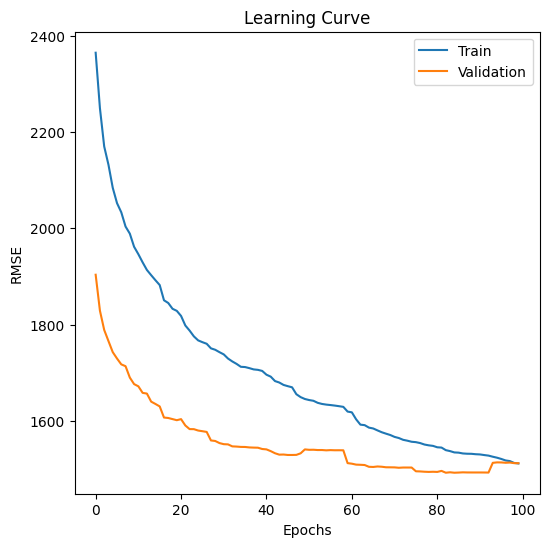

Plotting Feature Importance:


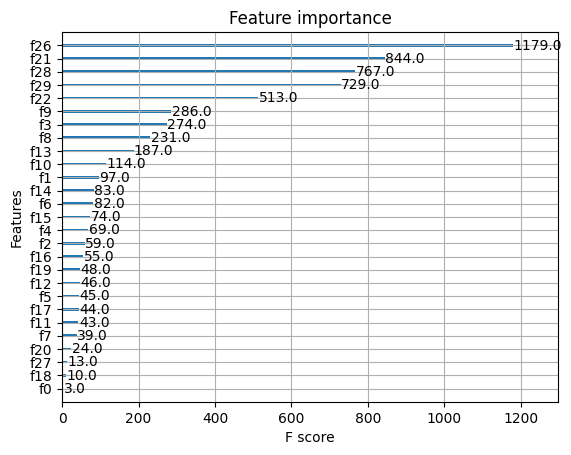

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [19]:
print("\nTest Set Metrics:")
eval_classifier.get_regression_metrics(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test)

# Optimization

In [22]:
import optuna
import xgboost as xgb
import polars as pl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# # # Define Data Splitting Framework 
# # time_split = TimeSplit(time_cutoff="2025-01-01")  # Adjust the time cutoff as needed
# # train_validation_split = TrainValidationSplit(val_ratio=0.2)  # 80% Train, 20% Validation

# # Split Data Using Your Framework
# df_test, df_leftover = time_split.data_split(df, "event_time_max")  # Test split
# df_train, df_val = train_validation_split.data_split(df_leftover)  # Train/Val split

# Extract Features and Target
target_col = "session_seconds_mean"

# X_train, y_train = train_validation_split.X_y_split(df_train, target_col)
# X_val, y_val = train_validation_split.X_y_split(df_val, target_col)
# X_test, y_test = time_split.X_y_split(df_test, target_col)

# Convert Polars DataFrames to NumPy
X_train, y_train = X_train, y_train
X_val, y_val = X_val, y_val
X_test, y_test = X_test, y_test

# X_train, y_train = clean_data(X_train, y_train)
# X_val, y_val = clean_data(X_val, y_val)
# X_test, y_test = clean_data(X_test, y_test)

# Define Hyperparameter Tuning Objective for RMSE
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "alpha": trial.suggest_float("alpha", 0, 5),
        "objective": "reg:squarederror",
        "eval_metric": "rmse", 
        "random_state": 42,
    }

    # Train Model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=10)

    # Predict
    y_pred = model.predict(X_val)

    # Compute RMSE
    return np.sqrt(mean_squared_error(y_val, y_pred))

# Run Optuna Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  

# Best Parameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-24 09:03:31,652] A new study created in memory with name: no-name-1085329e-a077-4070-acbd-98210e9fd1d0
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-02-24 09:03:34,661] Trial 0 finished with value: 1574.2883486574206 and parameters: {'max_depth': 4, 'learning_rate': 0.29609776880851746, 'n_estimators': 474, 'min_child_weight': 7, 'subsample': 0.8685774885314855, 'colsample_bytree': 0.9609615470736479, 'gamma': 2.572666374912261, 'lambda': 0.18574082139095116, 'alpha': 4.037465646186077}. Best is trial 0 with value: 1574.2883486574206.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_pa

Best Hyperparameters: {'max_depth': 10, 'learning_rate': 0.09365599088801628, 'n_estimators': 207, 'min_child_weight': 7, 'subsample': 0.7640389050660529, 'colsample_bytree': 0.8618043411183245, 'gamma': 3.7957449585346383, 'lambda': 3.764543401457139, 'alpha': 3.1752221391783166}


In [23]:
# Train Final Model with Best Parameters
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
eval_set = [(X_train, y_train), (X_val, y_val)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make Predictions
y_pred = final_model.predict(X_val)


Test Set Metrics:
R2:
0.42665473679953725
MSE:
2138812.9609257276
MAE:
187.5716552734375
Plotting Learning Curve:


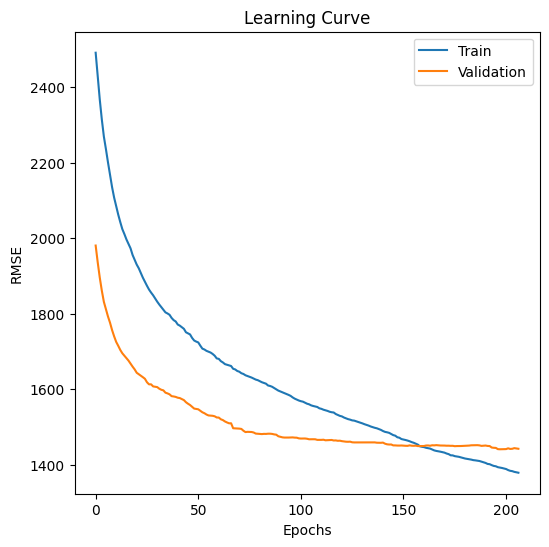

Plotting Feature Importance:


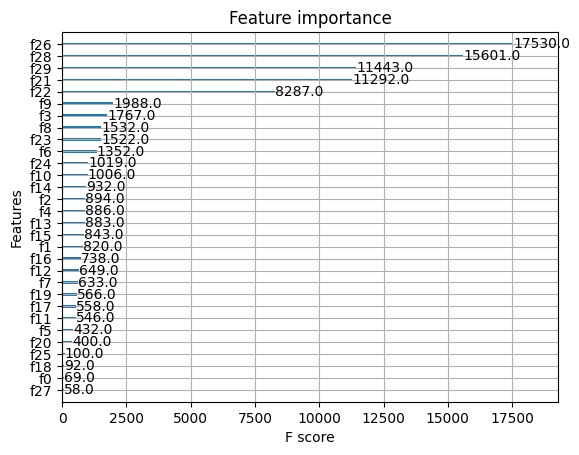

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [24]:
# Evaluate Model
eval_classifier = RegressionEvaluation(final_model)
print("\nTest Set Metrics:")
eval_classifier.get_regression_metrics(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test)


In [25]:
import pickle

# Define the filename for saving the model
model_filename = "xgb_regressor.pkl"

# Save the model using pickle
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as xgb_regressor.pkl
